# Supervised machine learning with Mol2vec

The notebooks illustrates how Mol2vec can be used to featurize and classify molecules using an Ames mutagenicity benchmark dataset by [Hansen et al.](http://pubs.acs.org/doi/abs/10.1021/ci900161g) as an example.
* [Featurize the molecules using pre-trained Mol2vec model](#Featurize-the-molecules-using-pre-trained-Mol2vec-model)
* [Train and validate Random Forest model trained using Mol2vec vectors](#Train-and-validate-Random-Forest-model-trained-using-Mol2vec-vectors)
* [Featurize molecules from the command line](#Featurize-molecules-from-the-command-line)

In [1]:
% matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import sys, os

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd()))+'/mol2vec')

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

Load the pre-processed [Ames](http://pubs.acs.org/doi/suppl/10.1021/ci900161g) dataset

In [3]:
df = PandasTools.LoadSDF('data/ames.sdf')

,ID,ROMol,class
0,2475-33-4,,0

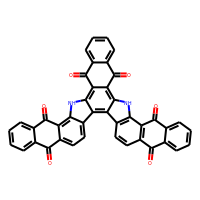

In [4]:
df.head(1)

In [5]:
len(df)

6506

### Featurize the molecules using pre-trained Mol2vec model

Load a pre-trained Mol2vec model which was trained on 20 million compounds downloaded from ZINC using:

* radius 1
* UNK to replace all identifiers that appear less than 4 times
* skip-gram and window size of 10
* resulting in 300 dimensional embeddings

In [6]:
model = word2vec.Word2Vec.load('models/model_300dim.pkl')

Generate "molecular sentences" that are then used to featurize the molecules (i.e. vectors of identifiers are extracted from Mol2vec model and summed up)

In [7]:
df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['ROMol'], 1)), axis=1)
df['mol2vec'] = [DfVec(x) for x in sentences2vec(df['sentence'], model, unseen='UNK')]

Extract the training data from the data frame

In [8]:
X = np.array([x.vec for x in df['mol2vec']])
y = np.array(df['class'].astype(int))

### Train and validate Random Forest model trained using Mol2vec vectors

Performance validation is done by stratified K-fold (4-fold CV) with shuffling

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

In [10]:
kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=0)

In [11]:
y_values = []
predictions = []
probas = []
for train, test in kf.split(X, y):
    clf = RandomForestClassifier(n_estimators=500, random_state=0)
    clf.fit(X[train], y[train])
    predictions.append(clf.predict(X[test]))
    probas.append(clf.predict_proba(X[test]).T[1]) # Probabilities for class 1
    y_values.append(y[test])
    del clf

Calculate performance metrics and plot them (ROC AUC)

In [12]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [13]:
aucs = [roc_auc_score(y, proba) for y, proba in zip(y_values, probas)]

In [14]:
np.mean(aucs), np.std(aucs)

(0.8699342575373864, 0.003797294667115103)

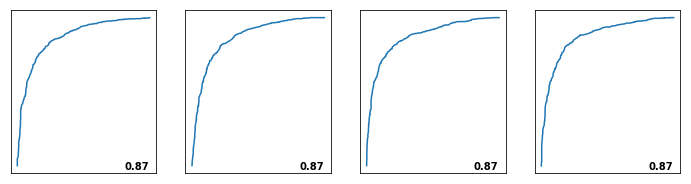

In [15]:
f, ((p1, p2, p3, p4)) = plt.subplots(1,4, squeeze=True, sharex=True, sharey=True, 
                                                    figsize=(12,3))

for y,proba,ax in zip(y_values, probas, (p1,p2,p3,p4)):
    tpr, fpr, _ = roc_curve(y, proba)
    auc = roc_auc_score(y, proba)
    ax.plot(tpr, fpr)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.text(0.95, 0.01, u"%0.2f" % auc,
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes, weight='bold',
            fontsize=10)
plt.show()

### Featurize molecules from the command line

Alternative to using Python functions is the command line `mol2vec` application. Type `mol2vec -h` for more information.

Calling command line application from Jupyter notebook

In [16]:
!mol2vec featurize -i data/ames.sdf -o data/ames.csv -m models/model_300dim.pkl --uncommon UNK -r 1 

Featurizing molecules.
Loading molecules.
Keeping only molecules that can be processed by RDKit.
Featurizing molecules.
Done!


Load embedding generated by the `mol2vec` application

In [17]:
df_2 = pd.read_csv('data/ames.csv', index_col=[0])

Not that unlike above where Mol2vec vectors are stored is data frame cells as DfVec objects command line application stores each dimension of the vectors as separate column (*mol2vec-000* to *mol2vec-n-dimensions*).

In [18]:
df_2.head()

,ID,class,Smiles,mol2vec-000,mol2vec-001,mol2vec-002,mol2vec-003,mol2vec-004,mol2vec-005,mol2vec-006,mol2vec-007,mol2vec-008,mol2vec-009,mol2vec-010,mol2vec-011,mol2vec-012,mol2vec-013,mol2vec-014,mol2vec-015,mol2vec-016,mol2vec-017,mol2vec-018,mol2vec-019,mol2vec-020,mol2vec-021,mol2vec-022,mol2vec-023,mol2vec-024,mol2vec-025,mol2vec-026,mol2vec-027,mol2vec-028,mol2vec-029,mol2vec-030,mol2vec-031,mol2vec-032,mol2vec-033,mol2vec-034,mol2vec-035,mol2vec-036,mol2vec-037,mol2vec-038,mol2vec-039,mol2vec-040,mol2vec-041,mol2vec-042,mol2vec-043,mol2vec-044,mol2vec-045,mol2vec-046,mol2vec-047,mol2vec-048,mol2vec-049,mol2vec-050,mol2vec-051,mol2vec-052,mol2vec-053,mol2vec-054,mol2vec-055,mol2vec-056,mol2vec-057,mol2vec-058,mol2vec-059,mol2vec-060,mol2vec-061,mol2vec-062,mol2vec-063,mol2vec-064,mol2vec-065,mol2vec-066,mol2vec-067,mol2vec-068,mol2vec-069,mol2vec-070,mol2vec-071,mol2vec-072,mol2vec-073,mol2vec-074,mol2vec-075,mol2vec-076,mol2vec-077,mol2vec-078,mol2vec-079,mol2vec-080,mol2vec-081,mol2vec-082,mol2vec-083,mol2vec-084,mol2vec-085,mol2vec-086,mol2vec-087,mol2vec-088,mol2vec-089,mol2vec-090,mol2vec-091,mol2vec-092,mol2vec-093,mol2vec-094,mol2vec-095,mol2vec-096,mol2vec-097,mol2vec-098,mol2vec-099,mol2vec-100,mol2vec-101,mol2vec-102,mol2vec-103,mol2vec-104,mol2vec-105,mol2vec-106,mol2vec-107,mol2vec-108,mol2vec-109,mol2vec-110,mol2vec-111,mol2vec-112,mol2vec-113,mol2vec-114,mol2vec-115,mol2vec-116,mol2vec-117,mol2vec-118,mol2vec-119,mol2vec-120,mol2vec-121,mol2vec-122,mol2vec-123,mol2vec-124,mol2vec-125,mol2vec-126,mol2vec-127,mol2vec-128,mol2vec-129,mol2vec-130,mol2vec-131,mol2vec-132,mol2vec-133,mol2vec-134,mol2vec-135,mol2vec-136,mol2vec-137,mol2vec-138,mol2vec-139,mol2vec-140,mol2vec-141,mol2vec-142,mol2vec-143,mol2vec-144,mol2vec-145,mol2vec-146,mol2vec-147,mol2vec-148,mol2vec-149,mol2vec-150,mol2vec-151,mol2vec-152,mol2vec-153,mol2vec-154,mol2vec-155,mol2vec-156,mol2vec-157,mol2vec-158,mol2vec-159,mol2vec-160,mol2vec-161,mol2vec-162,mol2vec-163,mol2vec-164,mol2vec-165,mol2vec-166,mol2vec-167,mol2vec-168,mol2vec-169,mol2vec-170,mol2vec-171,mol2vec-172,mol2vec-173,mol2vec-174,mol2vec-175,mol2vec-176,mol2vec-177,mol2vec-178,mol2vec-179,mol2vec-180,mol2vec-181,mol2vec-182,mol2vec-183,mol2vec-184,mol2vec-185,mol2vec-186,mol2vec-187,mol2vec-188,mol2vec-189,mol2vec-190,mol2vec-191,mol2vec-192,mol2vec-193,mol2vec-194,mol2vec-195,mol2vec-196,mol2vec-197,mol2vec-198,mol2vec-199,mol2vec-200,mol2vec-201,mol2vec-202,mol2vec-203,mol2vec-204,mol2vec-205,mol2vec-206,mol2vec-207,mol2vec-208,mol2vec-209,mol2vec-210,mol2vec-211,mol2vec-212,mol2vec-213,mol2vec-214,mol2vec-215,mol2vec-216,mol2vec-217,mol2vec-218,mol2vec-219,mol2vec-220,mol2vec-221,mol2vec-222,mol2vec-223,mol2vec-224,mol2vec-225,mol2vec-226,mol2vec-227,mol2vec-228,mol2vec-229,mol2vec-230,mol2vec-231,mol2vec-232,mol2vec-233,mol2vec-234,mol2vec-235,mol2vec-236,mol2vec-237,mol2vec-238,mol2vec-239,mol2vec-240,mol2vec-241,mol2vec-242,mol2vec-243,mol2vec-244,mol2vec-245,mol2vec-246,mol2vec-247,mol2vec-248,mol2vec-249,mol2vec-250,mol2vec-251,mol2vec-252,mol2vec-253,mol2vec-254,mol2vec-255,mol2vec-256,mol2vec-257,mol2vec-258,mol2vec-259,mol2vec-260,mol2vec-261,mol2vec-262,mol2vec-263,mol2vec-264,mol2vec-265,mol2vec-266,mol2vec-267,mol2vec-268,mol2vec-269,mol2vec-270,mol2vec-271,mol2vec-272,mol2vec-273,mol2vec-274,mol2vec-275,mol2vec-276,mol2vec-277,mol2vec-278,mol2vec-279,mol2vec-280,mol2vec-281,mol2vec-282,mol2vec-283,mol2vec-284,mol2vec-285,mol2vec-286,mol2vec-287,mol2vec-288,mol2vec-289,mol2vec-290,mol2vec-291,mol2vec-292,mol2vec-293,mol2vec-294,mol2vec-295,mol2vec-296,mol2vec-297,mol2vec-298,mol2vec-299
0,2475-33-4,0,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4ccccc4c(=O)c3c3[nH]c4c(ccc5c(=O)c6ccccc6c(=O)c54)c3c12,5.456957,-4.577423,-12.368451,16.083830,-3.434435,7.834656,-19.782095,2.486751,11.419450,11.417440,-9.061783,-0.875521,-17.590702,-0.892611,-10.669560,3.129902,7.490041,-8.228189,-7.295775,14.930939,3.110986,16.593018,31.732065,23.081747,-18.497038,-5.961964,-2.178754,-21

Extracting features for the machine learning

In [19]:
X = np.array(df_2[[x for x in df_2.columns if 'mol2vec' in x]])

In [20]:
X.shape

(6506, 300)